In [1]:
import pandas
from datetime import datetime

HACKER_DEPOSIT_ADDRS = [
    "0x3781e57863f00a2ebf77a8a7e47987c46474c9c9",
    "0x820a7a97dd146fd97f79881afdf4767624973368",
    "0x443e285a20e5f1df69e9db8bca8402c176524eb6",
    "0xf519e276958c3ef2dffd9b6b2d87d26859526505",
    "0xbe5e1ba665d397d5304f0f546cead0a1e44f242d",
    "0x1a98fcebebfea4ffbd0d5bf5e4650d71344f52ab",
    "0x54459d826a727393134c929ad1f4bc1e16f6f021",
    "0x34a17418cec67b82d08cf77a987941f99dc87c6b"
]

# suspected Kucoin hacker's address used to withdraw from TC
HACKER_WITHDRAW_ADDRS = [
    "0x8bd8746310d4ba8a0b044415bfac70db55ada5b0",
    "0x82e6b31b0fe94925b9cd1473d05894c86f277398"
]

KUCOIN_HACK_DATE = datetime(2020, 9, 25, 21, 2)

# TC contract addresses
ETH_01_ADDR = "0x12D66f87A04A9E220743712cE6d9bB1B5616B8Fc".lower()
ETH_1_ADDR =  "0x47CE0C6eD5B0Ce3d3A51fdb1C52DC66a7c3c2936".lower()
ETH_10_ADDR = "0x910Cbd523D972eb0a6f4cAe4618aD62622b39DbF".lower()
ETH_100_ADDR = "0xA160cdAB225685dA1d56aa342Ad8841c3b53f291".lower()

# withdraw() and deposit() function signatures
WITHDRAW_FUNC = "0x21a0adb6"
DEPOSIT_FUNC = "0xb214faa5"

# helper functions
def load_tx_csv(filename):
    return pandas.read_csv(
        filename,
        parse_dates=["block_timestamp"]
    )

def load_other_csv(filename):
    return pandas.read_csv(
        filename,
        parse_dates=["dt"]
    )

def shorten_addr(addr):
    return addr[0:6] + "..."

def stripTime(timestamp):
    return pandas.Timestamp(year=timestamp.year, month=timestamp.month, day=timestamp.day)

def to_addr(input):
    return "0x" + input[-40:]

def parse_withdrawal(input):
    data = input[10:]
    n = 64
    c = [data[i:i+n] for i in range(0, len(data), n)]
    return {
        "recipient": to_addr(c[3]),
        "relayer": to_addr(c[4]),
        "fee": int(c[5], 16) / (10 ** 18)
    }

def process_withdrawals(data):
    # select withdraw transactions
    withdrawals = data[
        data.input.str.startswith(WITHDRAW_FUNC)
    ] \
    .filter(items=["from_address", "block_timestamp", "input", "receipt_gas_used", "gas_price"]) \
    .sort_values("block_timestamp", ascending=False)

    withdrawals["tc_fee"] = withdrawals.input.apply(lambda row: parse_withdrawal(row)["fee"])
    withdrawals["tc_recipient"] = withdrawals.input.apply(lambda row: parse_withdrawal(row)["recipient"])
    withdrawals["tc_relayer"] = withdrawals.input.apply(lambda row: parse_withdrawal(row)["relayer"])
    withdrawals["tx_fee"] = withdrawals["receipt_gas_used"] * withdrawals["gas_price"]  / (10 ** 18)
    withdrawals["profit"] = withdrawals["tc_fee"] - withdrawals["tx_fee"]
    
    return withdrawals

TC_TRANSACTIONS = load_tx_csv("data/TC transactions.csv")
ETH_100_TXS = TC_TRANSACTIONS[TC_TRANSACTIONS.to_address == ETH_100_ADDR]

In [2]:
# Timeline plot

def timeline_plot(data, addresses, title, xlabel, filename, xsize, ysize, ymargin):
    import matplotlib.pyplot as plt
    import numpy as np
    import matplotlib.dates as mdates
    from datetime import datetime
    from matplotlib.dates import DateFormatter, MonthLocator, DayLocator, YearLocator
    from matplotlib import cm
    from matplotlib.colors import ListedColormap, LinearSegmentedColormap
    
    txes = data.filter(items=["block_timestamp", "from_address"])
    txes = txes[txes.from_address.isin(addresses)]

    fig, ax = plt.subplots()
    
    plt.rcParams["figure.figsize"] = [xsize, ysize]
    
    first_timestamp = sorted(txes.block_timestamp)[0]
    start_timestamp = first_timestamp - pandas.DateOffset(days=2)
    end_timestamp = sorted(txes.block_timestamp)[-1] + pandas.DateOffset(days=2)
    ax.set_xlim(
        start_timestamp,
        end_timestamp.to_pydatetime()
    )
    for i, addr in enumerate(reversed(addresses)):
        dates = txes[txes.from_address == addr].block_timestamp
        y = [shorten_addr(addr) for _ in dates]
        ax.scatter(dates, y, s=1, color='black')

    plt.title(title)
    plt.xlabel(xlabel)
    plt.gca().xaxis.set_minor_locator(DayLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter(''))
    ax.xaxis.set_minor_formatter(mdates.DateFormatter('%d'))

    ax.xaxis.grid(True, alpha=0.5)
    ax.yaxis.grid(True, alpha=0.5)
    
    ax.margins(y=ymargin)

    fig.patch.set_facecolor("white")
    plt.tight_layout()
    plt.show()

    fig.savefig(filename, dpi=300)
    plt.clf()

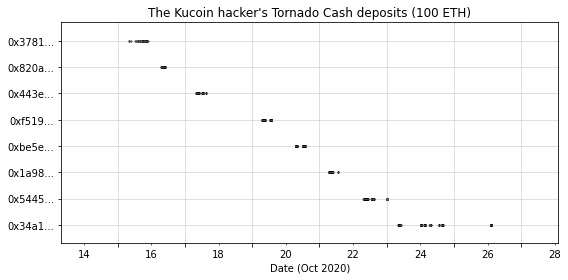

<Figure size 576x288 with 0 Axes>

In [23]:
# Deposit timeline
timeline_plot(
    ETH_100_TXS[ETH_100_TXS.input.str.startswith(DEPOSIT_FUNC)],
    HACKER_DEPOSIT_ADDRS,
    "The Kucoin hacker's Tornado Cash deposits (100 ETH)",
    "Date (Oct 2020)",
    "deposit_timeline.png",
    8,
    4,
    0.1
)

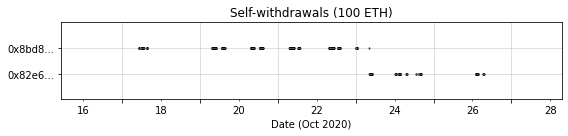

<Figure size 576x144 with 0 Axes>

In [35]:
# Withdrawal timeline

timeline_plot(
    ETH_100_TXS[ETH_100_TXS.input.str.startswith(WITHDRAW_FUNC)],
    HACKER_WITHDRAW_ADDRS,
    "Self-withdrawals (100 ETH)",
    "Date (Oct 2020)",
    "withdraw_timeline.png",
    8,
    2,
    1
)

In [5]:
# Receiving addresses

def print_receiving_addrs(addr):
    data = process_withdrawals(ETH_100_TXS)
    data = data[data.from_address == addr]
    
    recipients = data \
        .filter(items=["tc_recipient"]) \
        .groupby("tc_recipient")["tc_recipient"] \
        .count() \
        .sort_values(ascending=False)
    return recipients

print(HACKER_WITHDRAW_ADDRS[0])
print_receiving_addrs(HACKER_WITHDRAW_ADDRS[0])

0x8bd8746310d4ba8a0b044415bfac70db55ada5b0


tc_recipient
0x8e0d44afc80a874b8f2413df7e28db6e17b9da76    22
0xcf42ca97a61335ce0d407213a28dab5d21d2039e    20
0xaa3b3105e01896ca27f2ed8198c768b6311b5a44    20
0x85f26085c66108b789aff9a600986cf551b66b33    20
0x0001ab2fd9427a9ee06ea22294986a29a26cb307    14
0x375b2ae5cf4ba137aeb69759c98ede30c10b6c78    14
0xd85203a350b741bd6b59601fc008eeaddfa44333    14
0x43cfdf43b905d97fda7b41d5a33612b1472558af    14
0x75a31669d05a8a166683d6a81b84a8f92a6e78ae    14
0x6dffdfdb53f529911d214149b91741fd01b4c889    12
0x9c67d8383f1eeb6e2ff2b0d296aa6a51ea2858a1    10
0x52c9f5c2c0ec3c33d8ca6804d7c9faa695c81068    10
0x0cebd7d36ecbcb0fd90f0ee78fd4ae9f2b2422c0    10
0x2775c458d4122fcd62ae3fbd2993f8f2ecaaf32f    10
0x342f3705514b9a702e50f9fb6d4443d960d3ac5e    10
0xa37d93b9dc244d1a97dca8eee1d032ce20d1af98    10
0x4ac06dccfab65e6f63b0c8e3b1d455556bd33400    10
0x472d7a47a665810d7f6965c343a506616509927f    10
0x6030e5367bf58aff9437cc96234cec10774fb699    10
0xebae3e90675e995f57dad8dc96c370261eb9b325    10
0x8476c

In [6]:
print(HACKER_WITHDRAW_ADDRS[1])
print_receiving_addrs(HACKER_WITHDRAW_ADDRS[1])

0x82e6b31b0fe94925b9cd1473d05894c86f277398


tc_recipient
0xc609b3940be560c8c00e593bea47fb6ecef6b2c6    28
0xdc88f2867575d5e5edd824962c911e1e112bac09    22
0xd5bae2b1a704afd79fcc61513f5d3a7033b32f88    22
0xa4acafcb6f0fc028f524a95f717b93aa44b8922f    17
0x4a8a97876b42f6154c612cbd60e49ce308dc3048    14
0x0e2b72150e2837f791f5bd59be20179cea79e465    11
Name: tc_recipient, dtype: int64

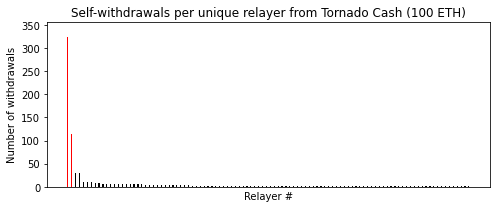

In [40]:
# Number of self-withdrawals per address

def plot_bars(data, xsize, ysize, title, xlabel, ylabel, filename, highlight_indices, legend=None, barwidth=0.3):
    import matplotlib.pyplot as plt
    %matplotlib inline

    plt.rcParams["figure.figsize"] = [xsize, ysize]
    fig, ax = plt.subplots()
    x_vals = [i for i, _ in enumerate(data.index)]
    colors = ['black' for _ in data]
    
    for i in highlight_indices:
        colors[i] = 'red'
        
    bars = ax.bar(x_vals, data, width=barwidth, color=colors)
    ax.margins(y=0.1)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks([])
    
    if legend is not None:
        ax.legend(legend, loc="upper right", facecolor='white', framealpha=1)

    fig.patch.set_facecolor("white")
    plt.tight_layout()
    plt.show()
    fig.savefig(filename, dpi=300)

data = process_withdrawals(ETH_100_TXS)
data = data[data.tc_fee == 0] \
    .filter(items=["from_address"]) \
    .groupby("from_address")["from_address"] \
    .count() \
    .sort_values(ascending=False)

plot_bars(data, 7, 3, "Self-withdrawals per unique relayer from Tornado Cash (100 ETH)", "Relayer #", "Number of withdrawals", "self_withdrawals.png", [0, 1])

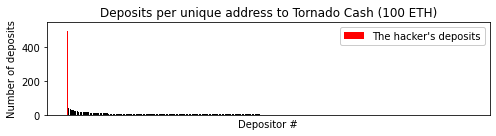

In [8]:
# nonhacker deposits

data = ETH_100_TXS[ETH_100_TXS.input.str.startswith(DEPOSIT_FUNC)]
hacker_deposits = data[data.from_address.isin(HACKER_DEPOSIT_ADDRS)].count().hash
nonhacker_deposits = data[~data.from_address.isin(HACKER_DEPOSIT_ADDRS)].count().hash

data = data[~data.from_address.isin(HACKER_DEPOSIT_ADDRS)] \
    .groupby("from_address")["from_address"] \
    .count()

data["HACKER"] = hacker_deposits
data = data.sort_values(ascending=False)

plot_bars(
    data,
    7,
    2,
    "Deposits per unique address to Tornado Cash (100 ETH)",
    "Depositor #", "Number of deposits", "all_deposits.png",
    [0],
    ["The hacker's deposits", "Other depositors"],
    0.8
)

In [9]:
# Timeline plot

def timeline_plot_long(data, addresses, title, xlabel, filename, xsize, ysize, ymargin):
    import matplotlib.pyplot as plt
    import numpy as np
    import matplotlib.dates as mdates
    from datetime import datetime
    from matplotlib.dates import DateFormatter, MonthLocator, DayLocator, YearLocator
    from matplotlib import cm
    from matplotlib.colors import ListedColormap, LinearSegmentedColormap
    
    txes = data.filter(items=["block_timestamp", "from_address"])
    txes = txes[txes.from_address.isin(addresses)]

    fig, ax = plt.subplots()
    
    plt.rcParams["figure.figsize"] = [xsize, ysize]
    
    first_timestamp = sorted(txes.block_timestamp)[0]
    start_timestamp = first_timestamp - pandas.DateOffset(days=2)
    end_timestamp = sorted(txes.block_timestamp)[-1] + pandas.DateOffset(days=2)
    ax.set_xlim(
        start_timestamp,
        end_timestamp.to_pydatetime()
    )
    for i, addr in enumerate(reversed(addresses)):
        dates = txes[txes.from_address == addr].block_timestamp
        y = [shorten_addr(addr) for _ in dates]
        ax.scatter(dates, y, s=1, color='black')

    plt.title(title)
    plt.xlabel(xlabel)
    plt.gca().xaxis.set_major_locator(MonthLocator())
    plt.gca().xaxis.set_minor_locator(DayLocator())
    #ax.xaxis.set_major_formatter(mdates.DateFormatter('%m'))
    #ax.xaxis.set_minor_formatter(mdates.DateFormatter(''))
    plt.gcf().autofmt_xdate()

    ax.xaxis.grid(True, alpha=0.5)
    ax.yaxis.grid(True, alpha=0.5)
    
    ax.margins(y=ymargin)

    fig.patch.set_facecolor("white")
    plt.tight_layout()
    plt.show()

    fig.savefig(filename, dpi=300)
    plt.clf()
    plt.cla()
    plt.close()

Hacker's first deposit occurred at:  2020-10-15 07:52:14+00:00
Number of withdrawals by the hacker:  437
Number of colluding depositors required: 14


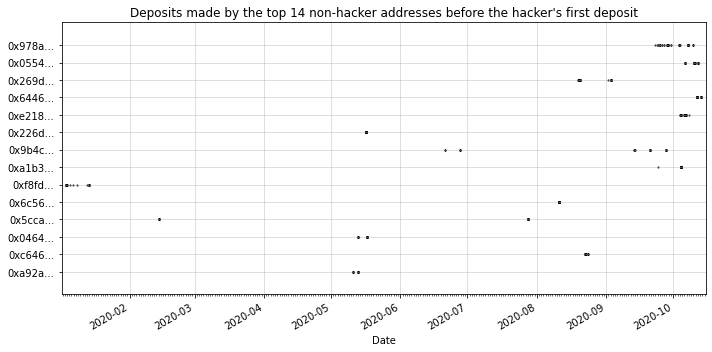

In [42]:
# collusion required to debunk the hypothesis

data = ETH_100_TXS[ETH_100_TXS.input.str.startswith(DEPOSIT_FUNC)]

# get the first deposit from the hacker

first_deposit_datetime = data[data.from_address.isin(HACKER_DEPOSIT_ADDRS)] \
    .sort_values("block_timestamp", ascending=True).iloc[0].block_timestamp

print("Hacker's first deposit occurred at: ", first_deposit_datetime)

nonhacker_deposits = data[~data.from_address.isin(HACKER_DEPOSIT_ADDRS)]
nonhacker_deposits = nonhacker_deposits[nonhacker_deposits.block_timestamp < first_deposit_datetime]

withdrawals = ETH_100_TXS[ETH_100_TXS.input.str.startswith(WITHDRAW_FUNC)]
num_hacker_withdrawals = withdrawals[withdrawals.from_address.isin(HACKER_WITHDRAW_ADDRS)].count().hash
print("Number of withdrawals by the hacker: ", num_hacker_withdrawals)

counts = nonhacker_deposits.groupby("from_address")["from_address"] \
    .count()\
    .sort_values(ascending=False)
    
i = 0
cum = 0
for count in counts:
    cum += count
    i += 1
    if cum > num_hacker_withdrawals:
        break
    
print("Number of colluding depositors required:", i)

colluders = counts.index[0: i]

timeline_plot_long(
    nonhacker_deposits,
    colluders,
    "Deposits made by the top " + str(i) + " non-hacker addresses before the hacker's first deposit",
    "Date",
    "colluders.png",
    10,
    5,
    0.1
)

# The plot may be messed up for some reason so just re-run this cell